In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [ ]:
from fastbook import *

In [ ]:
import requests
import pandas as pd
import json as json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.spatial
from collections import Counter

import math
import random

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels

from scipy.spatial import distance

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import metrics

import collections

# Preprocessing


## Read the million playlist dataset

In order to read the .json file with 1000 playlist, we use the python built-in module **open(file, 'r')**. We declare 4 methods, so that we can gather the data we want to:

*   **getTracksOfAllPlaylists** in order to get all Tracks of all Playlists or a specific amount of playlist tracks
*   **getTracksOfPlaylist** in order to get all Tracks of a Playlist
*   **getIdOfTracksOfAllPlaylists** in order to get Tracks with a specific Id of each playlist
*   **getTracksOfAllPlaylistsAndMine** gets one playlists, which is "your" playlist and k other playlists






In [ ]:
with open('/content/gdrive/MyDrive/Schule/Diplomarbeit/mpd.slice.0-999.json', 'r') as file:
  data = file.read()

dataset = json.loads(data)

def getTracksOfAllPlaylists(amount):
  if amount is None:
    amount = 1000
  temp = 0
  trackList = []
  for playlist in dataset['playlists']:
    if amount < temp:
       return trackList
    else:
      for track in playlist['tracks']:
        trackList.append(track)
    temp = temp + 1
  return trackList

def getTracksOfPlaylist(pid):
  trackList = []
  for playlist in dataset['playlists']:
    if playlist['pid'] == pid:
      trackList = (playlist['tracks'])
  return trackList
  
def getIdOfTrackOfAllPlaylists(pos):
  trackList = []
  for playlist in dataset['playlists']:
    trackList = (playlist['tracks'][pos])
  return trackList

def getTracksOfAllPlaylistsAndMine(pid, k_items):
  storedTracksList = []
  notStoredTracksList = []
  temp = 0
  storedTracksList = getTracksOfPlaylist(pid)
  for playlist in dataset['playlists']:
    if k_items < temp:
      return storedTracksList, notStoredTracksList
    elif playlist['pid'] != pid:
      for track in playlist['tracks']:
        notStoredTracksList.append(track)
    temp = temp + 1
  return storedTracksList, notStoredTracksList

## Prepare Pandas for general info

We get tracks from a playlist and store the important information in lists. Only *track_uri*, *track_name* and *artist_name* is relevant. We append them in seperate lists and create a Dictionary out of these lists afterwards. After this, we create a pandas DataFrame out of these dictionarys to vizualize the read data.

In [ ]:
storedTracksList = []
notStoredTracksList = []

#edm -> 631
#christmas -> 255

def prepareAllAndMine(pid, k_items):
  storedTracksList, notStoredTracksList = getTracksOfAllPlaylistsAndMine(pid, k_items)
  storedTracksDict = load(storedTracksList)
  notStoredTracksDict = load(notStoredTracksList)
  return storedTracksDict, notStoredTracksDict

def prepareAll():
  notStoredTracksList = getTracksOfAllPlaylists(1000)
  notStoredTracksDict = load(notStoredTracksList)
  return notStoredTracksDict

def load(trackList):
  trackIds = []
  trackNames = []
  artistNames = []

  for track in trackList:
    trackIds.append(track['track_uri'].split(":")[2])
    trackNames.append(track['track_name'])
    artistNames.append(track['artist_name'])

  return {"id": trackIds, "track_name": trackNames, "artist_name": artistNames}

In [ ]:
notStoredTracksDict = prepareAll()
print(notStoredTracksDict)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



a playlist, which we want to recommend some tracks:

### A selfmade playlist we want to analyse

In [ ]:
storedTracksIds = ['0uhJG7qeBA6obJRTGotNhX'
                   '3B54sVLJ402zGa6Xm4YGNe', 
                   '7hxHWCCAIIxFLCzvDgnQHX', 
                   '7xQAfvXzm3AkraOtGPWIZg', 
                   '7MJQ9Nfxzh8LPZ9e9u68Fq', 
                   '7Ie9W94M7OjPoZVV216Xus',
                   '3Ofmpyhv5UAQ70mENzB277',
                   '3I3WY0C7AQMe6Z6hMUQqd5',
                   '2eMqU82D3OleCi2SulF2Og',
                   '3pJnfyKoVePwVmljB6Wun1',
                   '6DCZcSspjsKoFjzjrWoCdn']

In [ ]:
storedTracksIdsGet = ",".join(storedTracksIds)

In order to send an API-Request, get a Bearer token from the Spotify Developer site. API-Token: https://developer.spotify.com/console/get-audio-features-track/?id=06AKEBrKUckW0KREUWRnvT

In [ ]:
token = "BQCIS-TUA0MaQFG8oUivjdrxt2F6f5EWvn8gHG3CQumNW6V5lbgHqYzxIvnZ2exwb-GHIkjWdASy10CWYwLylkPesNjDQAUJYtyxkEaDJEneGXepYeA28GogIq3-N6Ct-pCQI1kRyfBJd9LSLWJQjUhIVOyaSEMkP__lBU-pMb-Cvw5uHrdZBEHmkJFuFzaGntZxKd6dM9c"

In [ ]:
def getTrackInformation(idsList):
  url = f"https://api.spotify.com/v1/tracks/?ids={idsList}"
  r = requests.get(url, headers = {'Accept':'application/json', 'Content-Type':'application/json', 'Authorization':f'Bearer {token}'})
  features = r.json()

  trackIds = []
  trackNames = []
  artistNames = []
  
  for album in features['tracks']:
    trackIds.append(album['id'])
    trackNames.append(album['name'])
    artistNames.append(album['album']['artists'][0]['name'])
  print(trackIds)

  return {"id": trackIds, "track_name": trackNames, "artist_name": artistNames}

In [ ]:
storedTracksDict = getTrackInformation(storedTracksIdsGet)
storedTracksDict

['0uhJG7qeBA6obJRTGotNhX']


{'artist_name': ['Je$$e'],
 'id': ['0uhJG7qeBA6obJRTGotNhX'],
 'track_name': ['Barbie']}

Setting pd.set_options to *display.max_rows* allows us to see the complete pandas data frame.

In [ ]:
def make_dataframe(storedTracksDict, notStoredTracksDict):
  pd.set_option('display.max_rows', None)
  df_storedTracks = pd.DataFrame(storedTracksDict)
  df_notStoredTracks = pd.DataFrame(notStoredTracksDict)
  return df_storedTracks, df_notStoredTracks

df_storedTracks, df_notStoredTracks = make_dataframe(storedTracksDict, notStoredTracksDict)

In [ ]:
df_notStoredTracks.shape

(67503, 3)

In [ ]:
df_storedTracks.shape

(9, 3)

In [ ]:
df_notStoredTracks.head()

,id,track_name,artist_name
0,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears
2,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé
3,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake
4,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy


In [ ]:
df_storedTracks

,id,track_name,artist_name
0,0uhJG7qeBA6obJRTGotNhX,Barbie,Je$$e


drop the duplicate tracks:

In [ ]:
df_notStoredTracks = df_notStoredTracks.drop_duplicates()

In [ ]:
df_storedTracks = df_storedTracks.drop_duplicates()

In [ ]:
df_notStoredTracks.shape

(34443, 3)

In [ ]:
df_storedTracks.shape

(6, 3)

## Prepare ids of analysis

In the next section of the code the *ids* of each track are appended to a list in order to get a analysis of each track in the next step.

In [ ]:
def prepareIds(df_storedTracks, df_notStoredTracks):
  storedTracksIds = []
  notStoredTracksIds = []
  for x in df_storedTracks['id']:
    storedTracksIds.append(x)

  for x in df_notStoredTracks['id']:
    notStoredTracksIds.append(x)
  
  return storedTracksIds, notStoredTracksIds

storedTracksIds, notStoredTracksIds = prepareIds(df_storedTracks, df_notStoredTracks)

The ids list must be strings:

In [ ]:
print(len(storedTracksIds))
print(len(notStoredTracksIds))

6
34443


In [ ]:
def prepareIdsGet(storedTracksIds, notStoredTracksIds):
  storedTracksIdsGet = ",".join(storedTracksIds)
  notStoredTracksIdsGet = ",".join(notStoredTracksIds)
  return storedTracksIdsGet, notStoredTracksIdsGet

storedTracksIdsGet, notStoredTracksIdsGet = prepareIdsGet(storedTracksIds, notStoredTracksIds)

## Analysis using the Spotify-API

In order to analyse the data, we make use of the Spotify-Api, which provides us with the essential data for each Track. 3 Functions are defined for getting an analysis:

*   **getFeaturesOfTracksIds**: give a list of ids and get analysis of all tracks
*   **getFeaturesOfTracksIdsBigDataset**: you can give a list of ids and api requests are sent separately
*   **getFeaturesOfTrackId**: give one id and get the analysis of the track

All 3 return a Pandas DataFrame. In order to send an API-Request, get a Bearer token from the Spotify Developer site.
API-Token: https://developer.spotify.com/console/get-audio-features-track/?id=06AKEBrKUckW0KREUWRnvT


In [ ]:
big_data_values_list = []

def getFeaturesOfTrackIds(idsList):
  url = f"https://api.spotify.com/v1/audio-features/?ids={idsList}"
  r = requests.get(url, headers = {'Accept':'application/json', 'Content-Type':'application/json', 'Authorization':f'Bearer {token}'})
  features = r.json()
  print(features)
  return pd.DataFrame(features['audio_features'])

def getFeaturesOfTracksIdsBigDataset(idsList):
  for x in idsList:
    url = f"https://api.spotify.com/v1/audio-features/{x}"
    print(x)
    r = requests.get(url, headers = {'Accept':'application/json', 'Content-Type':'application/json', 'Authorization':f'Bearer {token}'})
    print(r)
    try:
      features = r.json()
    except:
      pass
    print(features)
    big_data_values_list.append(features)
  return pd.DataFrame(big_data_values_list)

def getFeaturesOfTrackId(id):
  url = f"https://api.spotify.com/v1/audio-features/{x}"
  r = requests.get(url, headers = {'Accept':'application/json', 'Content-Type':'application/json', 'Authorization':f'Bearer {token}'})
  features = r.json()
  return pd.DataFrame([features])

In [ ]:
df_storedTracksFeatures = getFeaturesOfTrackIds(storedTracksIdsGet)

{'audio_features': [{'danceability': 0.716, 'energy': 0.629, 'key': 8, 'loudness': -5.385, 'mode': 1, 'speechiness': 0.0528, 'acousticness': 0.0841, 'instrumentalness': 0, 'liveness': 0.103, 'valence': 0.321, 'tempo': 150.0, 'type': 'audio_features', 'id': '0uhJG7qeBA6obJRTGotNhX', 'uri': 'spotify:track:0uhJG7qeBA6obJRTGotNhX', 'track_href': 'https://api.spotify.com/v1/tracks/0uhJG7qeBA6obJRTGotNhX', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0uhJG7qeBA6obJRTGotNhX', 'duration_ms': 141046, 'time_signature': 4}]}


In [ ]:
df_notStoredTracksFeatures = getFeaturesOfTracksIdsBigDataset(notStoredTracksIds)

In [ ]:
df_storedTracksFeatures.shape

(10, 18)

In [ ]:
df_notStoredTracksFeatures.shape

In [ ]:
df_storedTracksFeatures.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.726,0.769,6,-5.043,1,0.123,0.02930,0.010100,0.104,0.733,97.985,audio_features,3B54sVLJ402zGa6Xm4YGNe,spotify:track:3B54sVLJ402zGa6Xm4YGNe,https://api.spotify.com/v1/tracks/3B54sVLJ402zGa6Xm4YGNe,https://api.spotify.com/v1/audio-analysis/3B54sVLJ402zGa6Xm4YGNe,233902,4
1,0.800,0.658,1,-6.142,0,0.079,0.25000,0.000000,0.111,0.462,140.042,audio_features,7hxHWCCAIIxFLCzvDgnQHX,spotify:track:7hxHWCCAIIxFLCzvDgnQHX,https://api.spotify.com/v1/tracks/7hxHWCCAIIxFLCzvDgnQHX,https://api.spotify.com/v1/audio-analysis/7hxHWCCAIIxFLCzvDgnQHX,195429,4
2,0.829,0.539,11,-7.359,0,0.208,0.13600,0.000002,0.103,0.388,99.960,audio_features,7xQAfvXzm3AkraOtGPWIZg,spotify:track:7xQAfvXzm3AkraOtGPWIZg,https://api.spotify.com/v1/tracks/7xQAfvXzm3AkraOtGPWIZg,https://api.spotify.com/v1/audio-analysis/7xQAfvXzm3AkraOtGPWIZg,149547,4
3,0.689,0.735,2,-4.545,1,0.267,0.00922,0.000720,0.365,0.059,171.403,audio_features,7MJQ9Nfxzh8LPZ9e9u68Fq,spotify:track:7MJQ9Nfxzh8LPZ9e9u68Fq,https://api.spotify.com/v1/tracks/7MJQ9Nfxzh8LPZ9e9u68Fq,https://api.spotify.com/v1/audio-analysis/7MJQ9Nfxzh8LPZ9e9u68Fq,320627,4
4,0.855,0.954,0,-1.190,0,0.264,0.52900,0.000000,0.205,0.668,114.635,audio_features,7Ie9W94M7OjPoZVV216Xus,spotify:track:7Ie9W94M7OjPoZVV216Xus,https://api.spotify.com/v1/tracks/7Ie9W94M7OjPoZVV216Xus,https://api.spotify.com/v1/audio-analysis/7Ie9W94M7OjPoZVV216Xus,248133,5


In [ ]:
df_notStoredTracksFeatures.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,error
0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI,226864.0,4.0,None
1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/audio-analysis/6I9VzXrHxO9rA9A5euc8Ak,198800.0,4.0,None
2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/audio-analysis/0WqIKmW4BTrj3eJFmnCKMv,235933.0,4.0,None
3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/audio-analysis/1AWQoqb9bSvzTjaLralEkT,267267.0,4.0,None
4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/audio-analysis/1lzr43nnXAijIGYnCT8M8H,227600.0,4.0,None


### Convert the features to a file

In [ ]:
def write_to_file(df_notStoredTracksFeatures):
  json_notStoredTracksFeatures = df_notStoredTracksFeatures.to_json()
  with open("/content/gdrive/MyDrive/Schule/Diplomarbeit/notStoredTracksFeatures.json", "w") as outfile:
    outfile.write(json_notStoredTracksFeatures)

In [ ]:
def read_from_file():
  df_notStoredTracksFeatures = pd.read_json('/content/gdrive/MyDrive/Schule/Diplomarbeit/notStoredTracksFeatures.json')
  df_notStoredTracksFeatures.shape
  return df_notStoredTracksFeatures

df_notStoredTracksFeatures = read_from_file()

In [ ]:
df_notStoredTracksFeatures.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,error
0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,0UaMYEvWZi0ZqiDOoHU3YI,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI,226864.0,4.0,None
1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,6I9VzXrHxO9rA9A5euc8Ak,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/audio-analysis/6I9VzXrHxO9rA9A5euc8Ak,198800.0,4.0,None
2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,0WqIKmW4BTrj3eJFmnCKMv,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/audio-analysis/0WqIKmW4BTrj3eJFmnCKMv,235933.0,4.0,None
3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,1AWQoqb9bSvzTjaLralEkT,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/audio-analysis/1AWQoqb9bSvzTjaLralEkT,267267.0,4.0,None
4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,1lzr43nnXAijIGYnCT8M8H,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/audio-analysis/1lzr43nnXAijIGYnCT8M8H,227600.0,4.0,None


### Prepare Data Frames for Recommender

#### Complete Dataframe

In [ ]:
def prepare_complete_dataframe(df_storedTracks, df_storedTracksFeatures, df_notStoredTracks, df_notStoredTracksFeatures):
  df_storedTracksComplete = df_storedTracks.merge(df_storedTracksFeatures, on="id")
  df_notStoredTracksComplete = df_notStoredTracks.merge(df_notStoredTracksFeatures, on="id")

  df_notStoredTracksComplete = df_notStoredTracksComplete.drop(['error'], axis=1)

  df_storedTracksComplete = df_storedTracksComplete.drop_duplicates().reset_index(drop=True)
  df_notStoredTracksComplete = df_notStoredTracksComplete.drop_duplicates().reset_index(drop=True)

  return df_storedTracksComplete, df_notStoredTracksComplete

In [ ]:
df_storedTracksComplete = df_storedTracks.merge(df_storedTracksFeatures, on="id")
df_notStoredTracksComplete = df_notStoredTracks.merge(df_notStoredTracksFeatures, on="id")

df_notStoredTracksComplete = df_notStoredTracksComplete.drop(['error'], axis=1)

df_storedTracksComplete = df_storedTracksComplete.drop_duplicates().reset_index(drop=True)
df_notStoredTracksComplete = df_notStoredTracksComplete.drop_duplicates().reset_index(drop=True)

In [ ]:
df_storedTracksComplete

,id,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,0uhJG7qeBA6obJRTGotNhX,Barbie,Je$$e,0.716,0.629,8,-5.385,1,0.0528,0.0841,0,0.103,0.321,150.0,audio_features,spotify:track:0uhJG7qeBA6obJRTGotNhX,https://api.spotify.com/v1/tracks/0uhJG7qeBA6obJRTGotNhX,https://api.spotify.com/v1/audio-analysis/0uhJG7qeBA6obJRTGotNhX,141046,4


In [ ]:
df_notStoredTracksComplete.head()

,id,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),Missy Elliott,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,audio_features,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI,https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI,226864.0,4.0
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,Britney Spears,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,audio_features,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/tracks/6I9VzXrHxO9rA9A5euc8Ak,https://api.spotify.com/v1/audio-analysis/6I9VzXrHxO9rA9A5euc8Ak,198800.0,4.0
2,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,Beyoncé,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,audio_features,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/tracks/0WqIKmW4BTrj3eJFmnCKMv,https://api.spotify.com/v1/audio-analysis/0WqIKmW4BTrj3eJFmnCKMv,235933.0,4.0
3,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,Justin Timberlake,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,audio_features,spotify:track:1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/tracks/1AWQoqb9bSvzTjaLralEkT,https://api.spotify.com/v1/audio-analysis/1AWQoqb9bSvzTjaLralEkT,267267.0,4.0
4,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,Shaggy,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,audio_features,spotify:track:1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/tracks/1lzr43nnXAijIGYnCT8M8H,https://api.spotify.com/v1/audio-analysis/1lzr43nnXAijIGYnCT8M8H,227600.0,4.0


#### All Dataframe

if we want a dataframe with all tracks, then merge these 2:

In [ ]:
df_all = pd.concat([df_storedTracksComplete, df_notStoredTracksComplete])

In [ ]:
df_all = df_all.drop_duplicates()

In [ ]:
df_data = df_all.drop(['id', 'track_name', 'artist_name', 'type', 'uri', 'track_href', 'analysis_url'], axis = 1)

#### Data Dataframe

Drop Data which are not features:

In [ ]:
def prepare_data_dataframe(df_storedTracksComplete, df_notStoredTracksComplete):
  df_storedTracksData = df_storedTracksComplete.drop(['track_name', 'artist_name', 'id', 'type', 'uri', 'track_href', 'analysis_url'], axis = 1)
  df_notStoredTracksData = df_notStoredTracksComplete.drop(['track_name', 'artist_name', 'id', 'type', 'uri', 'track_href', 'analysis_url'], axis = 1)
  return df_storedTracksData, df_notStoredTracksData

In [ ]:
df_storedTracksData = df_storedTracksComplete.drop(['track_name', 'artist_name', 'id', 'type', 'uri', 'track_href', 'analysis_url'], axis = 1)
df_notStoredTracksData = df_notStoredTracksComplete.drop(['track_name', 'artist_name', 'id', 'type', 'uri', 'track_href', 'analysis_url'], axis = 1)

In [ ]:
df_storedTracksData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.716,0.629,8,-5.385,1,0.0528,0.0841,0,0.103,0.321,150.0,141046,4


In [ ]:
df_notStoredTracksData.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.904,0.813,4.0,-7.105,0.0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,226864.0,4.0
1,0.774,0.838,5.0,-3.914,0.0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,198800.0,4.0
2,0.664,0.758,2.0,-6.583,0.0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,235933.0,4.0
3,0.892,0.714,4.0,-6.055,0.0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,267267.0,4.0
4,0.853,0.606,0.0,-4.596,1.0,0.0713,0.05610,0.000000,0.3130,0.654,94.759,227600.0,4.0


### Data explanation

We get a lot of data from the Spotify-Analysis API, I'll explain them in short:

1.   Danceability
> How suitable a track is for dancing, based on a combination of musical elements, including *tempo*, *rhythm*, *stability*, *beat strength*, and overall *regularity*. 

 *   **1.0** -> most danceable
 *   **0.0** -> least danceable

2.  Energy
> Perceptual measure of intensity and activity. Energetic tracks feel fast, loud and noisy. (Bsp.: Death metal has high energy)

 *   **1.0** -> most energy
 *   **0.0** -> least energy

3.  Key
> Integers map to pitches using standard Pitch Class Notation

 *   **0** = C
 *   **1** = C#/D
 *   **2** = D
 *   ...

4.   Loudness
> Loudness of a track in decibels (dB). Averaged across the entire track

  *   **0** -> loud
  *   **-60** -> silence

5.   Speechiness
> Presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.

 *   **0.66 < value** -> probably made entirely of spoken words
 *   **0.33 < value < 0.66** -> tracks, that may contain both music and speech
 *   **value < 0.33** -> most likely represent music and other non-speech-like-tracks

6.   Acousticness
> A confidence measure whether the track is acoustic.

 *   **1.0** -> most acoustic
 *   **0.0** -> least acoustic

7.   Instrumentalness
> Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal".

 *   **1.0** -> no vocal content
 *   **0.5 < value** -> instrumental track
 *   **0.0** -> vocal track

8.   Liveness
> Detects the presence of an audience in the recording.

 *   **1.0** -> track was performed live
 *   **0.8 < value** -> string likelihood that the track is live
 *   **0.0** -> track is not live

9.   Valence
> The musical positiveness conveyed by a track (happy, cheerful, euphoric) or (sad, depressed, angry)

 *   **1.0** -> most positive
 *   **0.0** -> least positive

10.   Tempo
> The overall estimated tempo of a track in beats per minute (BPM).

 *   Has a wide range approx. **90-150 BPM**

11.   Duration
> How long the track lasts

*   Most tracks last **2 to 5 minutes**

12.   Time Signature
> A notational convention to specify how many beats are in each bar (or measure)

*   Most tracks have a time-signature of **4**

[Source](https://towardsdatascience.com/machine-learning-and-music-classification-a-content-based-filtering-approach-f2c4eb13bade)



# Recommender

##Cosine-Similarity

In [ ]:
df_storedTracksComplete.shape

(6, 20)

In [ ]:
df_notStoredTracksComplete.shape

(14338, 20)

In [ ]:
df_storedTracksData.shape

(1, 13)

In [ ]:
df_notStoredTracksData.shape

(14338, 13)

### Minimizing Dimensions (Factors)

7 Factors:

In [ ]:
df_notStoredTracksDataReduced_seven = df_notStoredTracksData.drop(['key', 'mode', 'loudness', 'tempo', 'duration_ms', 'time_signature'], axis=1)
df_storedTracksDataReduced_seven = df_storedTracksData.drop(['key', 'mode', 'loudness', 'tempo', 'duration_ms', 'time_signature'], axis=1)

In [ ]:
df_storedTracksDataReduced_seven

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence
0,0.716,0.629,0.0528,0.0841,0,0.103,0.321


5 Factors:

In [ ]:
df_notStoredTracksDataReduced_five = df_notStoredTracksData.drop(['key', 'mode', 'loudness', 'tempo', 'duration_ms', 'time_signature', 'liveness', 'valence'], axis=1)
df_storedTracksDataReduced_five = df_storedTracksData.drop(['key', 'mode', 'loudness', 'tempo', 'duration_ms', 'time_signature', 'liveness', 'valence'], axis=1)

In [ ]:
df_storedTracksDataReduced_five

,danceability,energy,speechiness,acousticness,instrumentalness
0,0.726,0.76900,0.1230,0.02930,0.010100
1,0.800,0.65800,0.0790,0.25000,0.000000
2,0.829,0.53900,0.2080,0.13600,0.000002
3,0.689,0.73500,0.2670,0.00922,0.000720
4,0.855,0.95400,0.2640,0.52900,0.000000
5,0.778,0.69500,0.0913,0.17500,0.000000
6,0.418,0.03680,0.0499,0.99300,0.944000
7,0.271,0.01420,0.0510,0.99300,0.921000
8,0.458,0.00701,0.0438,0.99300,0.948000
9,0.754,0.44900,0.1090,0.03320,0.000083


In [ ]:
df_notStoredTracksData.head(10)

In [ ]:
df_storedTracksData

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.726,0.76900,6,-5.043,1,0.1230,0.02930,0.010100,0.1040,0.7330,97.985,233902,4
1,0.800,0.65800,1,-6.142,0,0.0790,0.25000,0.000000,0.1110,0.4620,140.042,195429,4
2,0.829,0.53900,11,-7.359,0,0.2080,0.13600,0.000002,0.1030,0.3880,99.960,149547,4
3,0.689,0.73500,2,-4.545,1,0.2670,0.00922,0.000720,0.3650,0.0590,171.403,320627,4
4,0.855,0.95400,0,-1.190,0,0.2640,0.52900,0.000000,0.2050,0.6680,114.635,248133,5
5,0.778,0.69500,4,-6.865,0,0.0913,0.17500,0.000000,0.1500,0.4720,149.996,132780,4
6,0.418,0.03680,11,-24.304,0,0.0499,0.99300,0.944000,0.0848,0.1190,111.355,161209,4
7,0.271,0.01420,0,-29.350,1,0.0510,0.99300,0.921000,0.1170,0.1360,71.286,148605,1
8,0.458,0.00701,8,-34.755,1,0.0438,0.99300,0.948000,0.1020,0.0939,118.444,171213,3


### Visualize the Data

0.716 0.629


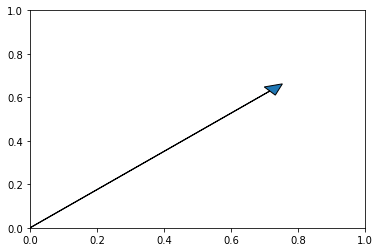

In [ ]:
def display_vectors(df_storedTracksData):
  for i, row in df_storedTracksData.iterrows():
    A = row[0]
    B = row[1]
    print(A, B)

    ax = plt.axes()
    
    ax.arrow(0.0, 0.0, A, B, head_width=0.05, head_length=0.05)
    #plt.annotate(f"A({A}, {B})", xy = (A, B), xytext=(A+0.5, B))

display_vectors(df_storedTracksData)

plt.xlim(0,1)
plt.ylim(0,1)

plt.show()
plt.close()

In [ ]:
def show_graph(ang1, ang2):
  fig = plt.figure()
  ax = plt.axes(projection='3d')

  xdata = df_storedTracksData['danceability']
  ydata = df_storedTracksData['energy']
  zdata = df_storedTracksData['acousticness']
  ax.scatter3D(xdata, ydata, zdata);

  ax.view_init(ang1, ang2)
  plt.show()

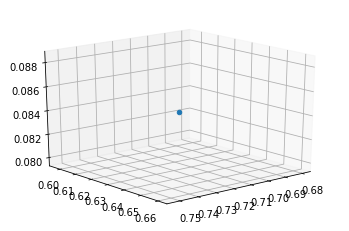

In [ ]:
show_graph(20,50)

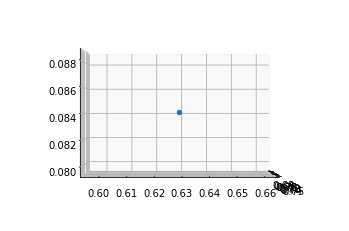

In [ ]:
show_graph(0,0)

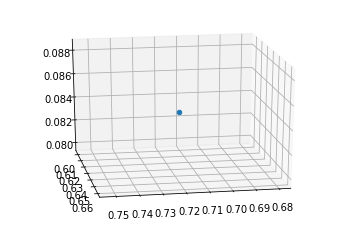

In [ ]:
show_graph(20, 80)

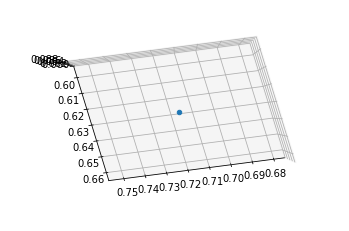

In [ ]:
show_graph(90, 80)

### Recommendation

In [ ]:
def recommend(X_test, X_train, metric):
  final_output = []
  nearest_first = []
  for i in range(len(X_test)):
    d = []
    for j in range(len(X_train)):
      if metric == 'e':
        dist = distance.euclidean(X_train[j], X_test[i])
      elif metric == 'c':
        dist = distance.cosine(X_train[j], X_test[i])
      d.append([dist, j])
    #d.sort()
    d = sorted(d, key=lambda x: x[0])
    #for each in my playlist pick 3 nearest
    nearest_first.append(d[0:3])
  for o in nearest_first:
    for x in o:
      final_output.append(x)
  final_output.sort()
  return final_output[:15]

In [ ]:
def get_recommendation():
  X_test = df_storedTracksDataReduced_seven.to_numpy()
  X_train = df_notStoredTracksDataReduced_seven.to_numpy()

  predictions = recommend(X_test, X_train, 'c')
  predictions = dict(predictions)

  ids = []
  names = []
  artists = []
  
  ls = []

  for key, value in predictions.items():
    ids.append(df_notStoredTracksComplete['id'][value])
    names.append(df_notStoredTracksComplete['track_name'][value])
    artists.append(df_notStoredTracksComplete['artist_name'][value])

  recommendation_data = pd.DataFrame({"Nr in Playlist:": predictions.values(), "id:": ids[0], 
                        "dst:": predictions.keys(), "name:": names,
                        "artist:": artists})

  df_recommendations = pd.DataFrame(recommendation_data)


  return df_recommendations


df_recommendations = get_recommendation()
df_recommendations

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


,Nr in Playlist:,id:,dst:,name:,artist:
0,3169,5nHTLEJ10zaqdnKqLriah4,0.000497,Carousel,Melanie Martinez
1,3757,5nHTLEJ10zaqdnKqLriah4,0.000766,Habits (Stay High),Tove Lo
2,11356,5nHTLEJ10zaqdnKqLriah4,0.000903,Wave's - Radio Edit,Slowly Drifting
3,167,5nHTLEJ10zaqdnKqLriah4,0.001213,The Freshmen,The Verve Pipe
4,980,5nHTLEJ10zaqdnKqLriah4,0.001433,Paparazzi,Lady Gaga


In [ ]:
df_notStoredTracksCompleteRec

In [ ]:
class Recommender:
  def __init__(self, playlist_id, data_loaded):
    self.data_loaded = data_loaded

  def main():
    storedTracksDict, notStoredTracksDict = prepareAllAndMine(playlist_id, 1000)
    df_storedTracks, df_notStoredTracks = make_dataframe(storedTracksDict, notStoredTracksDict)
    storedTracksIds, notStoredTracksIds = prepareIds(df_storedTracks, df_notStoredTracks)

    df_storedTracksFeatures = getFeaturesOfTracksIdsBigDataset(storedTracksIds)
    df_notStoredTracksFeatures = getFeaturesOfTracksIdsBigDataset(notStoredTracksIds)
    

  if __name__ == "__main__":
    main()

recommender = Recommender(True, 631)

In [ ]:
X = [[1,2,3], [4,5,6], [7,8,9]]
Y = [[1,5,2], [7,3,5], [3,6,9]]
Z = [[10,13,4], [11,4,9], [15,3,25]]

euclidean_dist = distance.euclidean(X[0],Y[0])
cosine_dist = distance.cosine(X[0], Y[0])
cosine_dist_linear = linear_kernel(X, Y)
print("euclidean: {}".format(euclidean_dist))
print("cosine: {}".format(cosine_dist))
print("cosine_linear: {}".format(cosine_dist_linear))

##KNN

In [ ]:
print(df_storedTracksData.shape)
print(df_notStoredTracksData.shape)

(6, 5)
(14338, 5)


In [ ]:
df_storedTracksDataTarget.iloc[10]['target']
dict_storedTracksDataTarget = df_storedTracksDataTarget.to_dict()
for key, value in dict_storedTracksDataTarget:
  print(key, value)

In [ ]:
X = df_storedTracksData
y = df_notStoredTracksData
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
y.head()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(126, 14)
(32, 14)


In [ ]:
y_train

### Classification

In [ ]:
######### probably optimal value:
int(math.sqrt(df_data.shape[0]))
#########

######### try to find better value
range_k = range(1, 20)
scores = {}
scores_list = []
for k in range_k:
  classifier = KNeighborsClassifier(n_neighbors=k)
  classifier.fit(X_train, y_train)
  y_pred = classifier.predict(X_test)
  scores[k] = metrics.accuracy_score(y_test, y_pred)
  scores_list.append(metrics.accuracy_score(y_test, y_pred))
result = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(result)
result1 = metrics.classification_report(y_test, y_pred)
print("Classification Report")
print(result1)

Text(0, 0.5, 'Accuracy')

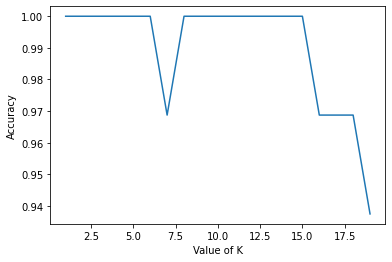

In [ ]:
plt.plot(range_k, scores_list)
plt.xlabel("Value of K")
plt.ylabel("Accuracy")

In [ ]:
df_data.shape

(158, 14)

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 7)
classifier.fit(X_train, y_train)
preds = classifier.predict(df_oneTrack)
print(preds)

##TF-IDF-Vectorizer

In [ ]:
df_allText = df_all.drop(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'], axis = 1)

In [ ]:
df_notStoredTracksText = df_notStoredTracksComplete.drop(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'], axis = 1)

In [ ]:
df_notStoredTracksComplete.head()

,id,track_name,artist_name,uri
1925,7w9bgPAmPTtrkt2v16QWvQ,Lose Yourself - Soundtrack Version,Eminem,spotify:track:7w9bgPAmPTtrkt2v16QWvQ
673,4hEl2wrneFEJbJ6SDYWd2f,Not Afraid,Eminem,spotify:track:4hEl2wrneFEJbJ6SDYWd2f
7264,4Re0d3C9jBhdXX0e12FdYu,Autumn Flowers,Omar Sosa,spotify:track:4Re0d3C9jBhdXX0e12FdYu
13284,0Qw0J8pQHyA8pmYgs75RdE,Armellodie,Chilly Gonzales,spotify:track:0Qw0J8pQHyA8pmYgs75RdE
10461,3DnLGuX4YU3PGein8vo5Zt,Orfeo et Eurydice: Mélodie for Piano Solo,Christoph Willibald Gluck,spotify:track:3DnLGuX4YU3PGein8vo5Zt


In [ ]:
df_allText.head(15)

,id,track_name,artist_name,uri
0,3B54sVLJ402zGa6Xm4YGNe,Unforgettable,French Montana,spotify:track:3B54sVLJ402zGa6Xm4YGNe
1,7hxHWCCAIIxFLCzvDgnQHX,"Lemonade (feat. Gunna, Don Toliver & NAV)",Internet Money,spotify:track:7hxHWCCAIIxFLCzvDgnQHX
2,7xQAfvXzm3AkraOtGPWIZg,Wow.,Post Malone,spotify:track:7xQAfvXzm3AkraOtGPWIZg
3,7MJQ9Nfxzh8LPZ9e9u68Fq,Lose Yourself,Various Artists,spotify:track:7MJQ9Nfxzh8LPZ9e9u68Fq
4,7Ie9W94M7OjPoZVV216Xus,Not Afraid,Eminem,spotify:track:7Ie9W94M7OjPoZVV216Xus
5,3Ofmpyhv5UAQ70mENzB277,Astronaut In The Ocean,Masked Wolf,spotify:track:3Ofmpyhv5UAQ70mENzB277
6,3I3WY0C7AQMe6Z6hMUQqd5,Vals De Rodrigues,Eric Badanti,spotify:track:3I3WY0C7AQMe6Z6hMUQqd5
7,2eMqU82D3OleCi2SulF2Og,Reveries,Haelg,spotify:track:2eMqU82D3OleCi2SulF2Og
8,3pJnfyKoVePwVmljB6Wun1,Sea Change,Stephan Moccio,spotify:track:3pJnfyKoVePwVmljB6Wun1
9,6DCZcSspjsKoFjzjrWoCdn,God's Plan,Drake,spotify:track:6DCZcSspjsKoFjzjrWoCdn


In [ ]:
def clean_data(x):
  if isinstance(x, list):
    return [str.lower(i.replace(" ", "")) for i in x]
  else:
    if isinstance(x, str):
      return str.lower(x.replace(" ", ""))
    else:
      return ''

In [ ]:
features = ['track_name', 'artist_name']
for feature in features:
  df_allText[feature] = df_allText[feature].apply(clean_data)

In [ ]:
df_allText.head(15)

,id,track_name,artist_name,uri
0,3B54sVLJ402zGa6Xm4YGNe,unforgettable,frenchmontana,spotify:track:3B54sVLJ402zGa6Xm4YGNe
1,7hxHWCCAIIxFLCzvDgnQHX,"lemonade(feat.gunna,dontoliver&nav)",internetmoney,spotify:track:7hxHWCCAIIxFLCzvDgnQHX
2,7xQAfvXzm3AkraOtGPWIZg,wow.,postmalone,spotify:track:7xQAfvXzm3AkraOtGPWIZg
3,7MJQ9Nfxzh8LPZ9e9u68Fq,loseyourself,variousartists,spotify:track:7MJQ9Nfxzh8LPZ9e9u68Fq
4,7Ie9W94M7OjPoZVV216Xus,notafraid,eminem,spotify:track:7Ie9W94M7OjPoZVV216Xus
5,3Ofmpyhv5UAQ70mENzB277,astronautintheocean,maskedwolf,spotify:track:3Ofmpyhv5UAQ70mENzB277
6,3I3WY0C7AQMe6Z6hMUQqd5,valsderodrigues,ericbadanti,spotify:track:3I3WY0C7AQMe6Z6hMUQqd5
7,2eMqU82D3OleCi2SulF2Og,reveries,haelg,spotify:track:2eMqU82D3OleCi2SulF2Og
8,3pJnfyKoVePwVmljB6Wun1,seachange,stephanmoccio,spotify:track:3pJnfyKoVePwVmljB6Wun1
9,6DCZcSspjsKoFjzjrWoCdn,god'splan,drake,spotify:track:6DCZcSspjsKoFjzjrWoCdn


In [ ]:
df_notStoredTracksText.head()

,id,track_name,artist_name,uri
0,0UaMYEvWZi0ZqiDOoHU3YI,losecontrol(feat.ciara&fatmanscoop),missyelliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,6I9VzXrHxO9rA9A5euc8Ak,toxic,britneyspears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0WqIKmW4BTrj3eJFmnCKMv,crazyinlove,beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,1AWQoqb9bSvzTjaLralEkT,rockyourbody,justintimberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,1lzr43nnXAijIGYnCT8M8H,itwasn'tme,shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H


In [ ]:
def create_soup(x):
  return x['track_name'] + ' ' + x['artist_name']

df_allText['soup'] = df_allText.apply(create_soup, axis=1)
df_allText[['soup']].head(2)

,soup
0,unforgettable frenchmontana
1,"lemonade(feat.gunna,dontoliver&nav) internetmoney"


In [ ]:
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(df_allText['soup'])
count_matrix.shape

(14348, 19939)

In [ ]:
cosine_sim = cosine_similarity(count_matrix, count_matrix)

In [ ]:
indices = pd.Series(df_allText.index, index=df_allText['uri'])

In [ ]:
indices[:30]

uri
spotify:track:7w9bgPAmPTtrkt2v16QWvQ     1925
spotify:track:4hEl2wrneFEJbJ6SDYWd2f      673
spotify:track:4Re0d3C9jBhdXX0e12FdYu     7264
spotify:track:0Qw0J8pQHyA8pmYgs75RdE    13284
spotify:track:3DnLGuX4YU3PGein8vo5Zt    10461
spotify:track:4Re0d3C9jBhdXX0e12FdYu     7264
spotify:track:7DI5lUQ13KXtmD1UkG70dT    10455
spotify:track:33R4sgQiAg8anGWc06juRD      938
spotify:track:0QJny1mMiQklvwaUmIwp0d    13306
spotify:track:1gTpngtG7wJGnGmlgKZ0ew    10602
spotify:track:33QqRNli0suoq8lBTy4ZTm     6125
spotify:track:7fBUnDgtSvYpYWuX4iAfns     3762
spotify:track:1kFlDnWmBTvCBxxeGDpIdp     9065
spotify:track:0yxnjcQcwlSiozp89EdcNA     8061
spotify:track:5AftJmmIpgmEMGkBtO69m7     2978
dtype: int64

In [ ]:
def get_recommendations(track_uri, cosine_sim=cosine_sim):
  idx = indices[track_uri]
  sim_scores = list(enumerate(cosine_sim[idx]))
  sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
  sim_scores = sim_scores[1:11]
  track_indices = [i[0] for i in sim_scores]
  return df_notStoredTracksComplete.iloc[track_indices]

In [ ]:
df_notStoredTracksCompleteNew = get_recommendations('spotify:track:6DCZcSspjsKoFjzjrWoCdn')

In [ ]:
df_notStoredTracksCompleteNew

,id,track_name,artist_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
10393,0e1Mjg7pA1J1f50W9kG63N,Best of Times ft. Phonte,Strong Arm Steady,0.557,0.666,8.0,-8.498,1.0,0.1550,0.0932,0.000000,0.4660,0.812,97.266,audio_features,spotify:track:0e1Mjg7pA1J1f50W9kG63N,https://api.spotify.com/v1/tracks/0e1Mjg7pA1J1f50W9kG63N,https://api.spotify.com/v1/audio-analysis/0e1Mjg7pA1J1f50W9kG63N,237040.0,4.0
319,1tbInvb7M0kUdlxfwh18qM,Canoe Canoa,Populous,0.712,0.467,4.0,-8.632,0.0,0.0342,0.0553,0.448000,0.0852,0.524,99.986,audio_features,spotify:track:1tbInvb7M0kUdlxfwh18qM,https://api.spotify.com/v1/tracks/1tbInvb7M0kUdlxfwh18qM,https://api.spotify.com/v1/audio-analysis/1tbInvb7M0kUdlxfwh18qM,177667.0,4.0
682,31G9RaSaDOI2NWcpnIp734,Goldie,A$AP Rocky,0.697,0.849,10.0,-4.953,0.0,0.2480,0.2280,0.000045,0.4930,0.734,81.956,audio_features,spotify:track:31G9RaSaDOI2NWcpnIp734,https://api.spotify.com/v1/tracks/31G9RaSaDOI2NWcpnIp734,https://api.spotify.com/v1/audio-analysis/31G9RaSaDOI2NWcpnIp734,192067.0,4.0
695,4cg1yakyRSIOjxKM2I7J1q,Digits,Young Thug,0.769,0.632,10.0,-4.228,0.0,0.0537,0.0325,0.000000,0.1160,0.294,131.932,audio_features,spotify:track:4cg1yakyRSIOjxKM2I7J1q,https://api.spotify.com/v1/tracks/4cg1yakyRSIOjxKM2I7J1q,https://api.spotify.com/v1/audio-analysis/4cg1yakyRSIOjxKM2I7J1q,176387.0,4.0
1313,3U9yv46nVSn3PkLsVcNIcA,Who Gon Stop Me,JAY Z,0.594,0.730,0.0,-4.638,0.0,0.1590,0.0408,0.000164,0.7150,0.378,133.880,audio_features,spotify:track:3U9yv46nVSn3PkLsVcNIcA,https://api.spotify.com/v1/tracks/3U9yv46nVSn3PkLsVcNIcA,https://api.spotify.com/v1/audio-analysis/3U9yv46nVSn3PkLsVcNIcA,256707.0,4.0
1479,6EdUE6TbcVzxfDnBZPTAg5,Fire Water Burn,Bloodhound Gang,0.687,0.565,7.0,-9.613,1.0,0.0316,0.0682,0.599000,0.1010,0.613,97.084,audio_features,spotify:track:6EdUE6TbcVzxfDnBZPTAg5,https://api.spotify.com/v1/tracks/6EdUE6TbcVzxfDnBZPTAg5,https://api.spotify.com/v1/audio-analysis/6EdUE6TbcVzxfDnBZPTAg5,291800.0,4.0
1506,24b20V609aI0WJ8LyxR8qx,The Game & Skrillex: El Chapo,The Game,0.754,0.909,6.0,-3.323,0.0,0.2300,0.1380,0.000000,0.2810,0.591,126.994,audio_features,spotify:track:24b20V609aI0WJ8LyxR8qx,https://api.spotify.com/v1/tracks/24b20V609aI0WJ8LyxR8qx,https://api.spotify.com/v1/audio-analysis/24b20V609aI0WJ8LyxR8qx,220079.0,4.0
1510,40oKW22ZNNkEdZLJTScaQI,Roll In Peace (feat. XXXTENTACION),Kodak Black,0.747,0.524,10.0,-6.807,0.0,0.2450,0.0306,0.000000,0.2000,0.363,140.053,audio_features,spotify:track:40oKW22ZNNkEdZLJTScaQI,https://api.spotify.com/v1/tracks/40oKW22ZNNkEdZLJTScaQI,https://api.spotify.com/v1/audio-analysis/40oKW22ZNNkEdZLJTScaQI,213132.0,4.0
1512,75GQIYnRaBg7ndHxhfYuQy,Go All The Way,Raspberries,0.305,0.849,9.0,-4.892,1.0,0.0999,0.5480,0.000134,0.0995,0.555,134.287,audio_features,spotify:track:75GQIYnRaBg7ndHxhfYuQy,https://api.spotify.com/v1/tracks/75GQIYnRaBg7ndHxhfYuQy,https://api.spotify.com/v1/audio-analysis/75GQIYnRaBg7ndHxhfYuQy,205347.0,4.0
1518,7Dm3dV3WPNdTgxoNY7YFnc,The Chain - Remastered,Fleetwood Mac,0.522,0.755,9.0,-6.950,1.0,0.0524,0.0517,0.000066,0.0781,0.637,151.796,audio_features,spotify:track:7Dm3dV3WPNdTgxoNY7YFnc,https://api.spotify.com/v1/tracks/7Dm3dV3WPNdTgxoNY7YFnc,https://api.spotify.com/v1/audio-analysis/7Dm3dV3WPNdTgxoNY7YFnc,269813.0,4.0


In [ ]:
df_storedTracksData, df_notStoredTracksDataNew = prepare_data_dataframe(df_storedTracksComplete, df_notStoredTracksCompleteNew)

In [ ]:
df_notStoredTracksDataNewReduced_seven = df_notStoredTracksDataNew.drop(['key', 'mode', 'loudness', 'tempo', 'duration_ms', 'time_signature'], axis=1)
df_notStoredTracksDataNewReduced_seven = df_notStoredTracksDataNewReduced_seven.drop_duplicates()